In [5]:
# trying to keep all values in the NN positive
import numpy as np
import matplotlib.pyplot as plt
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
import torch.nn as nn
import torch.nn.functional as F
import math
import os 
import subprocess
import time 
from datetime import datetime
import argparse
import scipy

def get_dataset(batch_size,norm_factor,dataset="mnist"):
    transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    if dataset == "mnist":
      trainset = torchvision.datasets.MNIST(root='./mnist_data', train=True,
                                              download=True, transform=transform)
      print("trainset: ", trainset)
      trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
      print("trainloader: ", trainloader)
      trainset = list(iter(trainloader))

      testset = torchvision.datasets.MNIST(root='./mnist_data', train=False,
                                          download=True, transform=transform)
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True)
      testset = list(iter(testloader))
      for i,(img, label) in enumerate(trainset):
          trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
      for i,(img, label) in enumerate(testset):
          testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
      return trainset, testset
    elif dataset == "fashion":
      trainset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=True,
                                            download=True, transform=transform)
      print("trainset: ", trainset)
      trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False)
      print("trainloader: ", trainloader)
      trainset = list(iter(trainloader))

      testset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=False,
                                          download=True, transform=transform)
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True)
      testset = list(iter(testloader))
      for i,(img, label) in enumerate(trainset):
          trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
      for i,(img, label) in enumerate(testset):
          testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
      return trainset, testset
    else:
      return ValueError("Dataset not found")

def np_norm(x):
      return np.linalg.norm(x.numpy())

def onehot(x):
    z = torch.zeros([len(x),10])
    for i in range(len(x)):
      z[i,x[i]] = 1
    return z.float().to(DEVICE)


### functions ###
def set_tensor(xs):
  return xs.float().to(DEVICE)

def tanh(xs):
    return torch.tanh(xs)

def tanh_plus_1(xs):
  return torch.tanh(xs) + 1



def linear(x):
    return x

def tanh_deriv(xs):
    return 1.0 - torch.tanh(xs) ** 2.0

def linear_deriv(x):
    return set_tensor(torch.ones_like((x)))

def relu(xs):
  return torch.clamp(xs,min=0)

def relu_deriv(xs):
  rel = relu(xs)
  rel[rel>0] = 1
  return rel 

def softmax(xs):
  return F.softmax(xs)

def sigmoid(xs):
  return F.sigmoid(xs)

def sigmoid_deriv(xs):
  return F.sigmoid(xs) * (torch.ones_like(xs) - F.sigmoid(xs))
   

def accuracy(out, L):
  if len(L.shape) == 1:
    # i.e. not onehotted
    L = onehot(L)
  B,l = out.shape
  total = 0
  for i in range(B):
    if torch.argmax(out[i,:]) == torch.argmax(L[i,:]):
      total +=1
  return total/ B

### loss functions
def mse_loss(out, label):
      return torch.sum((out-label)**2)

def mse_deriv(out,label):
      return 2 * (out - label)

ce_loss = nn.CrossEntropyLoss()

def cross_entropy_loss(out,label):
      return ce_loss(out,label)

def my_cross_entropy(out,label):
      return -torch.sum(label * torch.log(out + 1e-6))

def cross_entropy_deriv(out,label):
      return out - label

def parse_loss_function(loss_arg):
      if loss_arg == "mse":
            return mse_loss, mse_deriv
      elif loss_arg == "crossentropy":
            return my_cross_entropy, cross_entropy_deriv
      else:
            raise ValueError("loss argument not expected. Can be one of 'mse' and 'crossentropy'. You inputted " + str(loss_arg))


def boolcheck(x):
    return str(x).lower() in ["true", "1", "yes"]

def normalize(x):
  return (x - torch.mean(x)) / torch.std(x)


class FCLayer(object):
  def __init__(self, input_size, output_size,batch_size, fn, fn_deriv,use_layer_norm=True,purely_positive=True,posfn = torch.exp,log_activations=False, log_weights=False,log_outputs = False,device='cpu'):
    self.input_size = input_size
    self.output_size = output_size
    self.batch_size = batch_size
    self.fn = fn
    self.fn_deriv = fn_deriv
    self.purely_positive = purely_positive
    self.device = device
    self.weights = torch.abs(torch.empty((self.input_size, self.output_size)).normal_(0.0,0.5)).float().to(self.device)
    self.bias = torch.zeros((self.batch_size, self.output_size)).float().to(self.device)
    self.weights = nn.Parameter(self.weights)
    self.bias = nn.Parameter(self.bias)
    self.use_layer_norm = use_layer_norm
    self.layer_norm = normalize#torch.nn.LayerNorm(output_size)
    self.posfn = posfn
    self.log_activations = log_activations
    self.log_weights = log_weights
    self.log_outputs = log_outputs

  def forward(self, x):
    if self.purely_positive:
      self.activations = x @ self.posfn(self.weights)#F.softmax(self.weights) # works with softmax and exponential, to maintain the synaptic weight positivity. Exp is better since it is local vs softmax which needs a sum over all other weights
    else:
      self.activations = x @ self.weights
    #print("weights: ",(torch.exp(self.weights) <0).any()) # so this works!
    #print("activations: ", (self.activations <0).any())
    if self.purely_positive and (self.activations.cpu() < 0).any():
      print("Negative found!")
      print(self.activations)
      print(x)
      print(torch.exp(self.weights))
      crash
    print("LAYER: " + str(self.i))
    if self.log_activations:
      print("Activations mean: " + str(torch.mean(self.activations).item()) + " std: " + str(torch.std(self.activations).item()))
      print(self.activations[0,0:5].detach().numpy())
    if self.purely_positive:
      self.outs = self.activations #+ self.posfn(self.bias)
    else:
      self.outs = self.activations #+ self.bias
    #print("outs: ", (self.outs < 0).any())
    if self.use_layer_norm:
      out = self.fn(self.layer_norm(self.outs))
    else:
      out = self.fn(self.outs)
    if self.log_outputs:
      print("Output mean: " + str(torch.mean(out).item()) + " std: " + str(torch.std(out).item()))
      print(out[0,0:5])
    return out


class BackpropNet(object):
    def __init__(self, layers,loss_fn=None,purely_positive=True,log_gradients=False, log_outputs = False, log_activations=False,device="cpu"):
        self.layers = layers
        self.device = device
        self.loss_fn = loss_fn
        self.purely_positive = purely_positive
        self.log_gradients = log_gradients
        self.log_outputs = log_outputs
        self.log_activations = log_activations


        for i,l in enumerate(self.layers):
          l.purely_positive = self.purely_positive
          l.log_outputs = self.log_outputs
          l.log_activations = self.log_activations
          l.i = i

    def forward(self,x):
        for i,l in enumerate(self.layers):
            x = l.forward(x)
        return x

    def zero_grad(self):
        for l in self.layers:
            l.weights.grad = torch.zeros_like(l.weights).to(l.device)

    def train(self, trainset, testset,logdir,savedir, num_epochs,learning_rate,test=True):
      losses = []
      accs = []
      test_accs = []
      mean_train_accs = []
      mean_test_accs = []
      #begin training loop
      for n_epoch in range(num_epochs):
          epoch_train_accs = []
          print("Beginning epoch ",n_epoch)
          losslist = []
          acclist = []
          for n,(img,label) in enumerate(trainset):
              img = img.to(self.device)
              if self.loss_fn != cross_entropy_loss:
                label = onehot(label).to(self.device)
              else:
                    label = label.long().to(self.device)
              pred_outs = self.forward(img)
              #print("OUTS: ", pred_outs[0,0:5].detach().numpy())
              if self.loss_fn:
                    L = self.loss_fn(pred_outs, label)
              else:
                    L = torch.sum((pred_outs - label)**2)
              L.backward()
              acc = accuracy(pred_outs,label)
              #print("epoch: " + str(n_epoch) + " loss batch " + str(n) + "  " + str(L))
              #print("acc batch " + str(n) + "  " + str(acc))
              losslist.append(L.item())
              acclist.append(acc)
              epoch_train_accs.append(accs)
              #update
              for l in self.layers:
                  #SGD update
                  lgrad = l.weights.grad.clone()
                  if self.log_gradients:
                    print("LAYER: " + str(l.i))
                    print("GRADIENT MEAN: " + str(torch.mean(lgrad).item()) + " STD : " + str(torch.std(lgrad).item()) + " MAX: " +str(torch.max(lgrad).item()) + " MIN: " + str(torch.min(lgrad).item()) )
                  #print(lgrad)
                  l.weights = l.weights.detach().clone()
                  l.weights -= learning_rate  * lgrad
                  l.weights = nn.Parameter(l.weights)
              #zero grad weights just to be sure
          self.zero_grad()
          mean_train_accs.append(np.mean(np.array(epoch_train_accs)))
          if test:
              with torch.no_grad():
                  epoch_test_accs = []
                  for tn, (test_img, test_label) in enumerate(testset):
                      test_img = test_img.to(self.device)
                      labels = onehot(test_label).to(self.device)
                      pred_outs = self.forward(test_img)
                      test_acc = accuracy(pred_outs, labels)
                      test_accs.append(test_acc)
                      epoch_test_accs.append(test_acc)
          losses.append(np.mean(np.array(losslist)))
          accs.append(np.mean(np.array(acclist)))
          mean_test_accs.append(np.mean(np.array(epoch_test_accs)))
          print("EPOCH MEAN ACC: ", accs[-1])
          print("EPOCH MEAN TEST ACC: ", mean_test_accs[-1])
          #self.save_model(logdir,savedir,losses,accs,test_accs,mean_test_accs, mean_train_accs)
      if test:
          return losses, accs, test_accs
      else:
          return losses, accs

def negexp(x):
  return torch.exp(-x)

def abs(x):
  return torch.abs(x)

if __name__ == '__main__':
    global DEVICE
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size  = 64
    learning_rate = 0.01
    N_epochs = 10000
    loss_fn_name = "mse"
    dataset = "fashion"
    logdir = "/logs"
    savedir = "/save"
    f = relu
    df = relu_deriv
    posfn = abs

    loss_fn = None
    if loss_fn != "":
          loss_fn,loss_fn_deriv = parse_loss_function(loss_fn_name)
    trainset,testset = get_dataset(batch_size,1,dataset=dataset)
    l1 = FCLayer(784,300,batch_size,f,df,posfn = posfn,device=DEVICE)
    l2 = FCLayer(300,300,batch_size,f,df,posfn = posfn,device=DEVICE)
    l3 = FCLayer(300,100,batch_size,f,df,posfn=posfn,device=DEVICE)
    if loss_fn_name == "crossentropy":
      l4 = FCLayer(100,10,batch_size,softmax,linear_deriv,device=DEVICE,use_layer_norm=False)
    else:
      l4 = FCLayer(100,10,batch_size,linear,linear_deriv,device=DEVICE,use_layer_norm=False)

    layers =[l1,l2,l3,l4]
    net = BackpropNet(layers,loss_fn=loss_fn,purely_positive=True,log_gradients=False,log_outputs=False,log_activations=False,device=DEVICE)
    #losses, accs, test_accs = net.train(trainset[0:-2],testset[0:-2],logdir,savedir,N_epochs,learning_rate)
    net.train([trainset[0]], [trainset[0]],logdir, savedir,N_epochs, learning_rate)

trainset:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fashion_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x7f9f2f0bfd68>
Beginning epoch  0
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.109375
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  1
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  2
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  4
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  1709
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  1710
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  1711
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  1712
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  1713
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
EPOCH MEAN ACC:  0.140625
EPOCH MEAN TEST ACC:  0.140625
Beginning epoch  1714
LAYER: 0
LAYER: 1
LAYER: 2
LAYER: 3
LAYER: 0
LAYER: 

KeyboardInterrupt: ignored

In [19]:
from copy import deepcopy
positive_losses = deepcopy(losses)
positive_accs = deepcopy(accs)
positive_test_accs = deepcopy(test_accs)

In [16]:
from copy import deepcopy
standard_losses = deepcopy(losses)
standard_accs = deepcopy(accs)
standard_test_accs = deepcopy(test_accs)

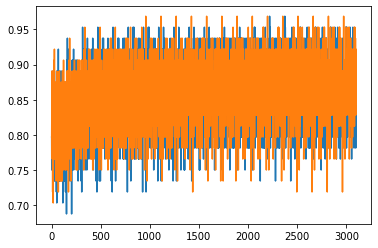

In [20]:
import matplotlib.pyplot as plt 
plt.plot(standard_test_accs)
plt.plot(positive_test_accs)
plt.show()

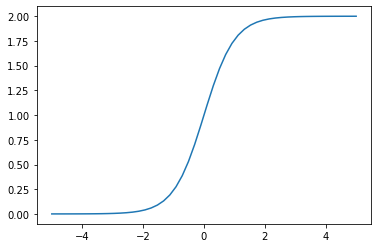

In [ ]:
# check activation functions
import numpy as np
import matplotlib.pyplot as plt

def tanh_mult(x):
  return np.tanh(x) * 5

def tanh_plus_1(x):
  return np.tanh(x) + 1

xs = np.linspace(-5,5,num=50)
ys = [tanh_plus_1(x) for x in xs]
plt.plot(xs,ys)
plt.show()